In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging
import tensorflow as tf
from skimage import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from sklearn.cluster import KMeans
import colorsys
#%matplotlib notebook

In [2]:
PATH_TO_IMGS = '/home/dl3/Object_localization/TensorFlow/workspace/training_v1/images/clustering/'

In [3]:
# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

def convert_bgr2rgb(img):
    # convert image from BGR to RBG
    conv_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return conv_img


def clustering(image, k):
    # function that creates clusters for the images in a folder and shows the images
    # pass images as rgb

    # reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values = image.reshape((-1, 3))

    # cluster the pixel intensities
    clt = KMeans(n_clusters = k)
    clt.fit(pixel_values)
        
    return clt

def create_segmented_image (image_shape, centers, labels):
    # convert back to 8 bit values
    centers = np.uint8(centers)

    # flatten the labels array
    labels = labels.flatten()

    # convert all pixels to the color of the centroids
    segmented_image = centers[labels.flatten()]
    
    # reshape back to the original image dimension
    segmented_image = segmented_image.reshape(image_shape)
    
    return segmented_image


def select_splash(labels, centers):
    i = 0
    splash_size = 0
    # select cluster based on colour of centers
    for colour in centers:
        # detect splash cluster through its higerh r value than other clusters
        if 130<colour[0]:
            # calculate splash size
            unique, counts = np.unique(labels, return_counts=True)
            a = dict(zip(unique, counts))
            splash_size = a[i]
            key = i
        else:
            i += 1
    
    return splash_size, key


def display_cluster(img1, clt, i):
    res = np.copy(img1)
    # keep only splash cluster in img2
    # keep only the cluster number i (turn other pixel into black)
    masked_image = np.copy(img1)

    # convert to the shape of a vector of pixel values
    masked_image = masked_image.reshape((-1, 3))
    # color (i.e cluster) to keep
    cluster = i
    masked_image[clt.labels_ != cluster] = [0, 0, 0]
    masked_image[clt.labels_ == cluster] = [255, 0, 0]
    # convert back to original shape and store in img2
    img2 = masked_image.reshape(img1.shape)
     
    # I want to put logo on top-left corner, So I create a ROI
    rows,cols,channels = img2.shape
    roi = img1[0:rows, 0:cols]
    
    # Now create a mask of logo and create its inverse mask also
    img2gray = cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)
    ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    
    # Now black-out the area of logo in ROI
    img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # Take only region of logo from logo image.
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)
    # Put logo in ROI and modify the main image
    dst = cv2.add(img1_bg,img2_fg)
    res[0:rows, 0:cols ] = dst
    
    return res

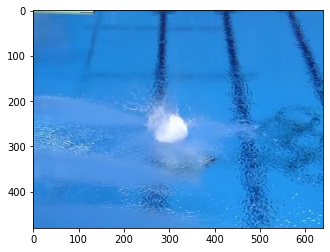

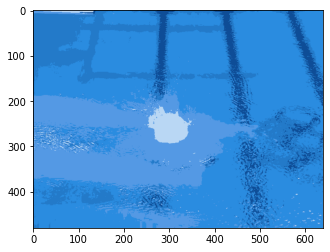

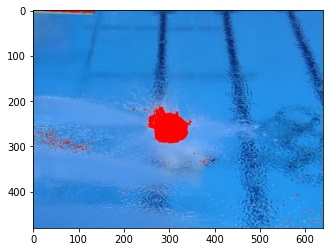

Splash size is  6367  pixels


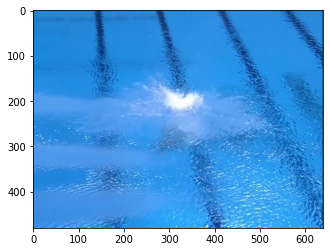

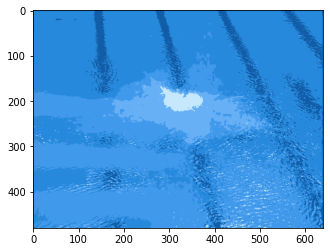

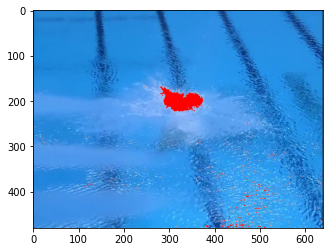

Splash size is  3786  pixels


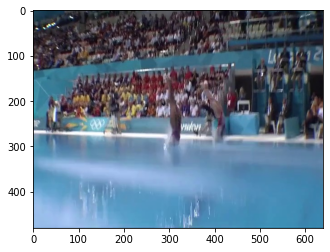

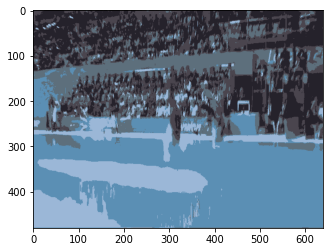

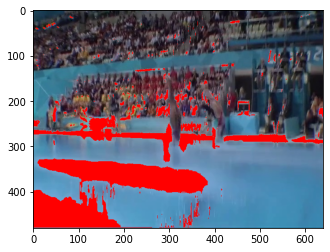

Splash size is  43622  pixels


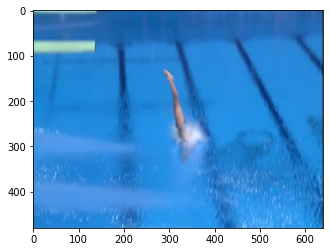

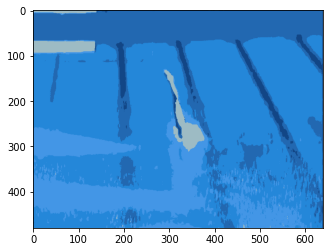

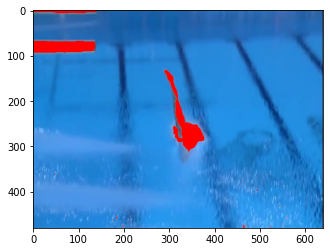

Splash size is  7982  pixels


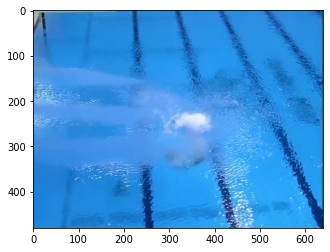

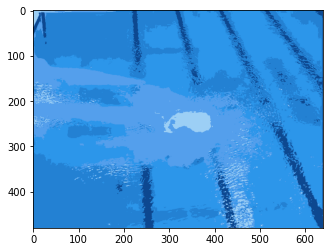

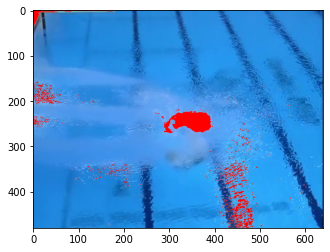

Splash size is  7913  pixels


In [4]:
# read all the Images from the foulder into a list
images = []
files = glob.glob (PATH_TO_IMGS+"/*.jpg")
for myFile in files:
    # print(myFile)
    image = cv2.imread (myFile)
    
    # convert to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    images.append (image_rgb)

# if you want to check the image shape
#print('images shape:', np.array(images).shape)

# iterate over the images and calculate the splash
for image in images:
    # clustering with k clusters
    clt = clustering(image, k = 5)
    
    # create segmented image
    segmented_image = create_segmented_image(image.shape, clt.cluster_centers_, clt.labels_)
    
    # select cluster with the splash and store size
    splash, spalsh_cluster_index = select_splash(clt.labels_, clt.cluster_centers_)

    # create overlayed image with splash cluster
    ovr_img = display_cluster(image, clt, spalsh_cluster_index)
    
    # show the image in comparison to original
    plt.imshow(image)
    plt.show()
    plt.imshow(segmented_image)
    plt.show()
    plt.imshow(ovr_img)
    plt.show()
    print ('Splash size is ', splash, ' pixels')

## calculate biggest splash per video

In [5]:
def analyse_video(video_path):
    cap = cv2.VideoCapture(video_path)
    predicted_frames = 0

    fig = plt.figure()
    viewer = fig.add_subplot()
    plt.ion() # Turns interactive mode on (probably unnecessary)
    fig.show() # Initially shows the figure
    
    biggest_splash = [0,0,0]

    while True:
        # Read frame from camera#
        ret, image_np = cap.read()
        if ret == True:
            predicted_frames += 1
            image_rgb = convert_bgr2rgb(image_np)

            # clustering with k clusters
            clt2 = clustering(image_rgb, k = 5)

            # shape back to original image
            segmented_image = create_segmented_image(image_rgb.shape, clt2.cluster_centers_, clt2.labels_)

            # select cluster with the splash and store size
            splash, spalsh_cluster_index = select_splash(clt2.labels_, clt2.cluster_centers_)

            # create overlayed image with splash cluster
            ovr_img = display_cluster(image_rgb, clt2, spalsh_cluster_index)
            
            # check for biggest splash and store
            if biggest_splash[1] < splash:
                    biggest_splash[0] = predicted_frames
                    biggest_splash[1] = splash
                    biggest_splash[2] = ovr_img
            
            # Display output
            splash_text = 'Splash: ' + str(splash) +' pixels'
            print(predicted_frames,splash_text)
            viewer.clear() # Clears the previous image
            viewer.imshow(ovr_img) # Loads the new image
            viewer.set_title(splash_text)
            #plt.pause(.1) # Delay in seconds
            fig.canvas.draw() # Draws the image to the screen
            
        else:
            break
            
    cap.release()
    print('Biggest splash:', biggest_splash[1])
    print('Is frame:', biggest_splash[0])

benchmark.mp4
1 Splash: 17406 pixels
2 Splash: 16947 pixels
3 Splash: 15962 pixels
4 Splash: 14094 pixels


KeyboardInterrupt: 

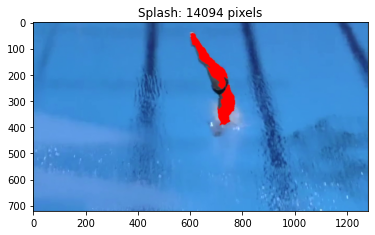

In [6]:
# making predictions for all videos in a directory
directory = 'test_videos/'
#file_paths = os.listdir(directory)
file_paths = ['benchmark.mp4']
for path in file_paths:
    print(path)
    analyse_video(directory +path)